In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import math
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
import EnergyPricesLibrary as Ep
import CustomMetrics

from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [32]:
def build_model(hourly_input_shape,daily_input_shape,image_input_shape,n_steps_out=24):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)
    input_3 = tf.keras.layers.Input(shape=image_input_shape)

    model_1_1 = tf.keras.layers.GRU(units=448,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),dropout=0.36,return_sequences=True)(input_1)
    model_1_1 = tf.keras.layers.GRU(units=128,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.09),dropout=0.36,return_sequences=False)(model_1_1)
    model_1_1 = tf.keras.layers.Dense(units=n_steps_out,activation=None)(model_1_1)

    model_2_2 = tf.keras.layers.GRU(units=256,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(input_2)
    model_2_2 = tf.keras.layers.GRU(units=512,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0),dropout=0,return_sequences=True)(model_2_2)
    model_2_2 = tf.keras.layers.Flatten()(model_2_2)
    model_2_2 = tf.keras.layers.Dense(units=n_steps_out,activation=None)(model_2_2)

    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=8,kernel_size=7,activation='relu',padding='valid'))(input_3)
    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=3))(model_3)
    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=8,kernel_size=3,activation='relu',padding='valid'))(model_3)
    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=5))(model_3)
    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(model_3)
    model_3 = tf.keras.layers.LSTM(units=64,activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(l1=0.105),dropout=0.99,return_sequences=False,stateful=False)(model_3)
    model_3 = tf.keras.layers.Dense(units=n_steps_out,activation=None)(model_3)

    output = tf.keras.layers.Add()([model_1_1, model_2_2, model_3])
    
    output = tf.keras.layers.Dense(units=n_steps_out,activation=None)(output)

    full_model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    
    return full_model

def make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                     trainX_D, trainY_D, testX_D, testY_D,
                     trainX_H, trainY_H, testX_H, testY_H,
                     trainX_I, trainY_I, testX_I, testY_I,
                     n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict([trainX_H,trainX_D,trainX_I])
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict([testX_H,testX_D,testX_I])
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_D_y.inverse_transform(trainPredict)
    trainY = scaler_D_y.inverse_transform(trainY_D.reshape(trainY_D.shape[0]*n_steps_out,len_output_features))
    
    testPredict = scaler_D_y.inverse_transform(testPredict)
    testY = scaler_D_y.inverse_transform(testY_D.reshape(testY_D.shape[0]*n_steps_out,len_output_features))
        
    return trainPredict,trainY,testPredict,testY

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    testMAPE  = Ep.MAPE(testPredict,testY)
    
    train_sMAPE  = Ep.sMAPE(trainY,trainPredict)
    test_sMAPE  = Ep.sMAPE(testY,testPredict)
    
    return trainMAPE,testMAPE,train_sMAPE,test_sMAPE

In [3]:
data_diaria_path = os.path.join('..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Diaria.xlsx')
data_diaria = pd.read_excel(data_diaria_path)
data_diaria = data_diaria.set_index('Fecha')

In [4]:
data_horaria_path = os.path.join('..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [5]:
climatic_images_prcp_dir = os.path.join('..','..','..','dataset','Climatic Images','PRCP')
climatic_images_tavg_dir = os.path.join('..','..','..','dataset','Climatic Images','TAVG')

In [6]:
precio_bolsa_path = os.path.join('..','..','..','dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [7]:
nombre_series_diaria = data_diaria.columns.values
nombre_series_horaria = data_horaria.columns.values

In [8]:
data_horaria_full = pd.concat([data_horaria,precio_bolsa],axis=1)

In [9]:
data_horaria.shape,data_diaria.shape, precio_bolsa.shape

((177480, 85), (7395, 119), (177480, 1))

## Build Window

In [10]:
lista_fechas = list()
lista_rutas = list()
for prcp_file,tavg_file in zip(os.listdir(climatic_images_prcp_dir),os.listdir(climatic_images_tavg_dir)):
    fecha = prcp_file.split('.')[0]
    ruta_prcp = os.path.join(climatic_images_prcp_dir,prcp_file)
    ruta_tavg = os.path.join(climatic_images_tavg_dir,tavg_file)
    lista_fechas.append(fecha)
    lista_rutas.append([ruta_prcp,ruta_tavg])

In [11]:
d = 'All'
start_date_train = '2000-02-01'
start_date_val = '2020-01-01'
start_date_test = '2020-04-01'
end_date_test = '2020-05-01'
n_steps_out=24
output_columns = ['$kWh']

In [12]:
dataset_df = pd.DataFrame(lista_rutas,index=lista_fechas,columns=['Precipitacion','Temperatura'])
 
n_steps_in  = 5
overlap = 1

inputs_columns=dataset_df.columns.values
len_output_features = len(output_columns)

IMG_HEIGHT,IMG_WIDTH = 128,128

results = Ep.SplitTimeseriesMultipleTimesBackAhead_DifferentTimes_Images(df_x=dataset_df,df_y=precio_bolsa,
                                                                         day=d,
                                                                         start_date_train=start_date_train,
                                                                         start_date_val=start_date_val,
                                                                         start_date_test=start_date_test,
                                                                         end_date_test=end_date_test,n_steps_out=n_steps_out,
                                                                         n_steps_in=n_steps_in,overlap=overlap,
                                                                         output_features=output_columns,
                                                                         input_features=inputs_columns,
                                                                         IMG_HEIGHT=IMG_HEIGHT,IMG_WIDTH=IMG_WIDTH)

trainX_I,trainY_I,valX_I,valY_I,testX_I,testY_I,scaler_y_I,dataset_x_I,dataset_y_I = results

In [13]:
n_steps_in = 5
overlap = 1
inputs_columns = nombre_series_diaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead_differentTimes(df_x=data_diaria,
                                                                  df_y=precio_bolsa,
                                                                  day=d,
                                                                  start_date_train=start_date_train,start_date_val=start_date_val,
                                                                  start_date_test=start_date_test,end_date_test=end_date_test,
                                                                  n_steps_out=n_steps_out,n_steps_in=n_steps_in,
                                                                  overlap=overlap,input_features=inputs_columns,
                                                                  output_features=output_columns)

trainX_D,trainY_D,valX_D,valY_D,testX_D,testY_D,scaler_D_x,scaler_D_y,dataset_x_D, dataset_y_D = results

In [14]:
n_steps_in = 120
overlap = 24
inputs_columns = nombre_series_horaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead(df=data_horaria_full,
                                                   day=d,
                                                   start_date_train=start_date_train,start_date_val=start_date_val,
                                                   start_date_test=start_date_test,end_date_test=end_date_test,
                                                   n_steps_out=n_steps_out,n_steps_in=n_steps_in,overlap=overlap,
                                                   input_features=inputs_columns,output_features=output_columns)

trainX_H,trainY_H,valX_H,valY_H,testX_H,testY_H,scaler_H_x,scaler_H_y,df2_H,dataset_H = results

### Train

In [15]:
'Diaria:',trainX_D.shape,trainY_D.shape,'Horaria:',trainX_H.shape, trainY_H.shape,'Imagenes:',trainX_I.shape, trainY_I.shape

('Diaria:',
 (7269, 5, 119),
 (7269, 24, 1),
 'Horaria:',
 (7269, 120, 85),
 (7269, 24, 1),
 'Imagenes:',
 (7269, 5, 128, 128, 6),
 (7269, 24, 1))

In [16]:
'Diaria:',valX_D.shape,valY_D.shape,'Horaria:',valX_H.shape,valY_H.shape,'Imagenes:',valX_I.shape,valY_I.shape

('Diaria:',
 (91, 5, 119),
 (91, 24, 1),
 'Horaria:',
 (91, 120, 85),
 (91, 24, 1),
 'Imagenes:',
 (91, 5, 128, 128, 6),
 (91, 24, 1))

In [17]:
trainX_D = np.concatenate([trainX_D,valX_D])
trainY_D = np.concatenate([trainY_D,valY_D])

trainX_H = np.concatenate([trainX_H,valX_H])
trainY_H = np.concatenate([trainY_H,valY_H])

trainX_I = np.concatenate([trainX_I,valX_I])
trainY_I = np.concatenate([trainY_I,valY_I])

In [18]:
'Diaria:',trainX_D.shape, trainY_D.shape,'Horaria:',trainX_H.shape, trainY_H.shape,'Imagenes:',trainX_I.shape, trainY_I.shape

('Diaria:',
 (7360, 5, 119),
 (7360, 24, 1),
 'Horaria:',
 (7360, 120, 85),
 (7360, 24, 1),
 'Imagenes:',
 (7360, 5, 128, 128, 6),
 (7360, 24, 1))

### Test

In [19]:
'Diaria:',testX_D.shape, testY_D.shape,'Horaria:',testX_H.shape, testY_H.shape,'Imagenes:',testX_I.shape, testY_I.shape

('Diaria:',
 (30, 5, 119),
 (30, 24, 1),
 'Horaria:',
 (30, 120, 85),
 (30, 24, 1),
 'Imagenes:',
 (30, 5, 128, 128, 6),
 (30, 24, 1))

## Model

In [45]:
log_dir = os.path.join('logs','ModeloCompleto_I5_Suma-2')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=True,
                                                          update_freq='epoch')

callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          min_lr=1e-5,
                                                          patience=5,
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

callbacks = [callback_reduce_lr,early_stopping,callback_tensorboard]

In [46]:
hourly_input_shape = (trainX_H.shape[1],trainX_H.shape[2])
daily_input_shape = (trainX_D.shape[1],trainX_D.shape[2])
images_input_shape = trainX_I[0].shape

model = build_model(hourly_input_shape,daily_input_shape,images_input_shape)

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 5, 128, 128, 0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 5, 122, 122,  2360        input_9[0][0]                    
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 5, 40, 40, 8) 0           time_distributed_10[0][0]        
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 5, 119)]     0                                            
_______________________________________________________________________________________

In [47]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),
              loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
              metrics=[tf.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.MeanAbsolutePercentageError(),
                       CustomMetrics.symmetric_mean_absolute_percentage_error])

In [48]:
import json

model_json = model.to_json()
with open("ModeloCompleto_I5_Suma-2.json", "w") as json_file:
    json_file.write(model_json)

In [49]:
model.fit([trainX_H,trainX_D,trainX_I], trainY_D, validation_data=([testX_H,testX_D,testX_I],testY_D),
               epochs=200,callbacks=callbacks,verbose=1)

Epoch 1/200
230/230 [==============================] - 32s 138ms/step - loss: 5402.5718 - mean_absolute_error: 0.2889 - mean_absolute_percentage_error: 44212.5430 - symmetric_mean_absolute_percentage_error: 4027.2786 - val_loss: 5235.6514 - val_mean_absolute_error: 0.5402 - val_mean_absolute_percentage_error: 690.5784 - val_symmetric_mean_absolute_percentage_error: 3869.9292
Epoch 2/200
230/230 [==============================] - 22s 97ms/step - loss: 5299.4360 - mean_absolute_error: 0.2742 - mean_absolute_percentage_error: 42278.3594 - symmetric_mean_absolute_percentage_error: 3942.6697 - val_loss: 5208.3511 - val_mean_absolute_error: 0.5475 - val_mean_absolute_percentage_error: 699.0836 - val_symmetric_mean_absolute_percentage_error: 3860.4414
Epoch 3/200
230/230 [==============================] - 23s 98ms/step - loss: 5215.5571 - mean_absolute_error: 0.2525 - mean_absolute_percentage_error: 52051.0156 - symmetric_mean_absolute_percentage_error: 3876.2429 - val_loss: 5212.4014 - val_m

Epoch 22/200
230/230 [==============================] - 22s 96ms/step - loss: 3300.0127 - mean_absolute_error: 0.0457 - mean_absolute_percentage_error: 5231.8125 - symmetric_mean_absolute_percentage_error: 2223.3508 - val_loss: 4714.2363 - val_mean_absolute_error: 0.4369 - val_mean_absolute_percentage_error: 558.8782 - val_symmetric_mean_absolute_percentage_error: 3643.4272
Epoch 23/200
230/230 [==============================] - 23s 98ms/step - loss: 3259.5400 - mean_absolute_error: 0.0439 - mean_absolute_percentage_error: 6351.7988 - symmetric_mean_absolute_percentage_error: 2194.4875 - val_loss: 4694.6035 - val_mean_absolute_error: 0.4330 - val_mean_absolute_percentage_error: 554.7983 - val_symmetric_mean_absolute_percentage_error: 3635.3328
Epoch 24/200
230/230 [==============================] - 22s 97ms/step - loss: 3216.2505 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 5602.1665 - symmetric_mean_absolute_percentage_error: 2162.6650 - val_loss: 4693.7192 - val_me

Epoch 44/200
230/230 [==============================] - 23s 99ms/step - loss: 2562.0039 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 4712.1743 - symmetric_mean_absolute_percentage_error: 1718.7887 - val_loss: 4183.9766 - val_mean_absolute_error: 0.3375 - val_mean_absolute_percentage_error: 432.9807 - val_symmetric_mean_absolute_percentage_error: 3345.8481
Epoch 45/200
230/230 [==============================] - 23s 101ms/step - loss: 2534.7012 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 4517.9146 - symmetric_mean_absolute_percentage_error: 1701.6575 - val_loss: 4134.5439 - val_mean_absolute_error: 0.3320 - val_mean_absolute_percentage_error: 426.0811 - val_symmetric_mean_absolute_percentage_error: 3306.6538
Epoch 46/200
230/230 [==============================] - 22s 97ms/step - loss: 2508.0769 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 4900.1143 - symmetric_mean_absolute_percentage_error: 1685.3259 - val_loss: 4098.7129 - val_m

Epoch 66/200
230/230 [==============================] - 23s 100ms/step - loss: 1968.9709 - mean_absolute_error: 0.0209 - mean_absolute_percentage_error: 2770.8535 - symmetric_mean_absolute_percentage_error: 1356.7317 - val_loss: 3533.4983 - val_mean_absolute_error: 0.2406 - val_mean_absolute_percentage_error: 309.9347 - val_symmetric_mean_absolute_percentage_error: 2925.9207
Epoch 67/200
230/230 [==============================] - 23s 101ms/step - loss: 1952.5924 - mean_absolute_error: 0.0208 - mean_absolute_percentage_error: 3090.6533 - symmetric_mean_absolute_percentage_error: 1349.5448 - val_loss: 3499.6550 - val_mean_absolute_error: 0.2330 - val_mean_absolute_percentage_error: 299.6707 - val_symmetric_mean_absolute_percentage_error: 2901.1187
Epoch 68/200
230/230 [==============================] - 23s 100ms/step - loss: 1928.1078 - mean_absolute_error: 0.0205 - mean_absolute_percentage_error: 3019.0569 - symmetric_mean_absolute_percentage_error: 1333.9567 - val_loss: 3448.1807 - val

Epoch 88/200
230/230 [==============================] - 23s 100ms/step - loss: 1569.5569 - mean_absolute_error: 0.0163 - mean_absolute_percentage_error: 2078.3640 - symmetric_mean_absolute_percentage_error: 1090.8496 - val_loss: 2996.0532 - val_mean_absolute_error: 0.1531 - val_mean_absolute_percentage_error: 195.9278 - val_symmetric_mean_absolute_percentage_error: 2518.9985
Epoch 89/200
230/230 [==============================] - 23s 101ms/step - loss: 1552.9822 - mean_absolute_error: 0.0161 - mean_absolute_percentage_error: 2021.9402 - symmetric_mean_absolute_percentage_error: 1077.5297 - val_loss: 2958.7146 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 189.1229 - val_symmetric_mean_absolute_percentage_error: 2484.8347
Epoch 90/200
230/230 [==============================] - 23s 101ms/step - loss: 1543.4739 - mean_absolute_error: 0.0160 - mean_absolute_percentage_error: 1800.3920 - symmetric_mean_absolute_percentage_error: 1071.1161 - val_loss: 2997.9978 - val

Epoch 110/200
230/230 [==============================] - 23s 100ms/step - loss: 1340.9951 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 1668.0265 - symmetric_mean_absolute_percentage_error: 917.9662 - val_loss: 2692.9702 - val_mean_absolute_error: 0.1051 - val_mean_absolute_percentage_error: 132.8716 - val_symmetric_mean_absolute_percentage_error: 2271.0317
Epoch 111/200
230/230 [==============================] - 23s 101ms/step - loss: 1332.7960 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 2063.1758 - symmetric_mean_absolute_percentage_error: 911.9354 - val_loss: 2673.4478 - val_mean_absolute_error: 0.1050 - val_mean_absolute_percentage_error: 133.2681 - val_symmetric_mean_absolute_percentage_error: 2253.6794
Epoch 112/200
230/230 [==============================] - 23s 100ms/step - loss: 1323.5173 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 1454.3169 - symmetric_mean_absolute_percentage_error: 904.8219 - val_loss: 2650.5129 - val

Epoch 132/200
230/230 [==============================] - 23s 99ms/step - loss: 1196.6289 - mean_absolute_error: 0.0126 - mean_absolute_percentage_error: 1509.6849 - symmetric_mean_absolute_percentage_error: 817.4290 - val_loss: 2463.8647 - val_mean_absolute_error: 0.0839 - val_mean_absolute_percentage_error: 106.3325 - val_symmetric_mean_absolute_percentage_error: 2085.5745
Epoch 133/200
230/230 [==============================] - 23s 101ms/step - loss: 1189.7959 - mean_absolute_error: 0.0126 - mean_absolute_percentage_error: 1662.4443 - symmetric_mean_absolute_percentage_error: 812.3929 - val_loss: 2540.7546 - val_mean_absolute_error: 0.0838 - val_mean_absolute_percentage_error: 106.3771 - val_symmetric_mean_absolute_percentage_error: 2164.2429
Epoch 134/200
230/230 [==============================] - 23s 99ms/step - loss: 1183.6146 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 1544.2324 - symmetric_mean_absolute_percentage_error: 807.9707 - val_loss: 2475.2205 - val_m

Epoch 154/200
230/230 [==============================] - 24s 106ms/step - loss: 1103.2859 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 1172.3108 - symmetric_mean_absolute_percentage_error: 758.7308 - val_loss: 2298.4084 - val_mean_absolute_error: 0.0719 - val_mean_absolute_percentage_error: 92.0498 - val_symmetric_mean_absolute_percentage_error: 1954.5315
Epoch 155/200
230/230 [==============================] - 25s 107ms/step - loss: 1097.1194 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 1489.7076 - symmetric_mean_absolute_percentage_error: 753.9177 - val_loss: 2269.0908 - val_mean_absolute_error: 0.0709 - val_mean_absolute_percentage_error: 91.0051 - val_symmetric_mean_absolute_percentage_error: 1926.5658
Epoch 156/200
230/230 [==============================] - 23s 99ms/step - loss: 1095.9575 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 1348.8075 - symmetric_mean_absolute_percentage_error: 754.0847 - val_loss: 2340.7900 - val_me

Epoch 176/200
230/230 [==============================] - 34s 148ms/step - loss: 1037.7844 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 1286.2379 - symmetric_mean_absolute_percentage_error: 719.0872 - val_loss: 2154.2620 - val_mean_absolute_error: 0.0619 - val_mean_absolute_percentage_error: 79.5530 - val_symmetric_mean_absolute_percentage_error: 1836.0818
Epoch 177/200
230/230 [==============================] - 34s 146ms/step - loss: 1038.3148 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 1352.6116 - symmetric_mean_absolute_percentage_error: 720.6292 - val_loss: 2149.3389 - val_mean_absolute_error: 0.0634 - val_mean_absolute_percentage_error: 81.3158 - val_symmetric_mean_absolute_percentage_error: 1832.1881
Epoch 178/200
230/230 [==============================] - 34s 149ms/step - loss: 1031.1736 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 1132.5350 - symmetric_mean_absolute_percentage_error: 714.4785 - val_loss: 2007.6843 - val_m

### Validación

In [50]:
model.evaluate(x=[testX_H,testX_D,testX_I], y=testY_D)

1/1 [==============================] - 0s 4ms/step - loss: 2094.6147 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 74.9259 - symmetric_mean_absolute_percentage_error: 1794.8972


[2094.61474609375, 0.05846215784549713, 74.92591094970703, 1794.897216796875]

In [51]:
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                                                         trainX_D, trainY_D, testX_D, testY_D,
                                                         trainX_H, trainY_H, testX_H, testY_H,
                                                         trainX_I, trainY_I, testX_I, testY_I,
                                                         n_steps_out,len_output_features)

In [52]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((176640, 1), (176640, 1), (720, 1), (720, 1))

In [53]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

In [54]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE

(0.20921862791468163, 0.6787522116419877, 20.02749660535139, 69.72444224435937)

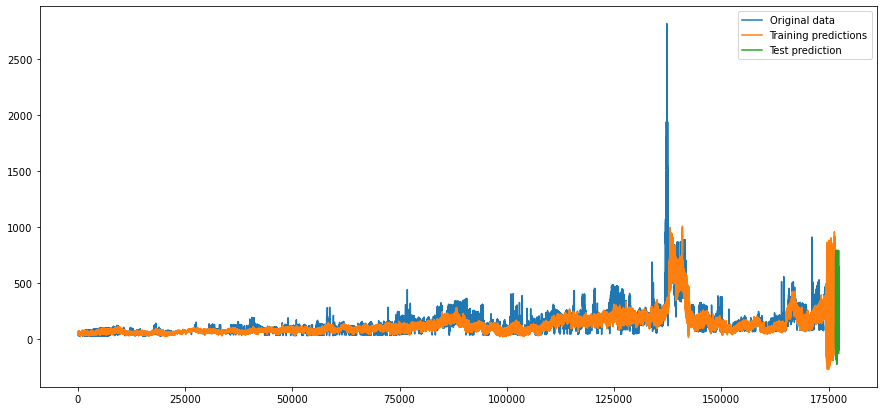

In [55]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset_y_D[0].reshape(1,1),trainPredict[:-1]))

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(np.concatenate((trainY,testY)),label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

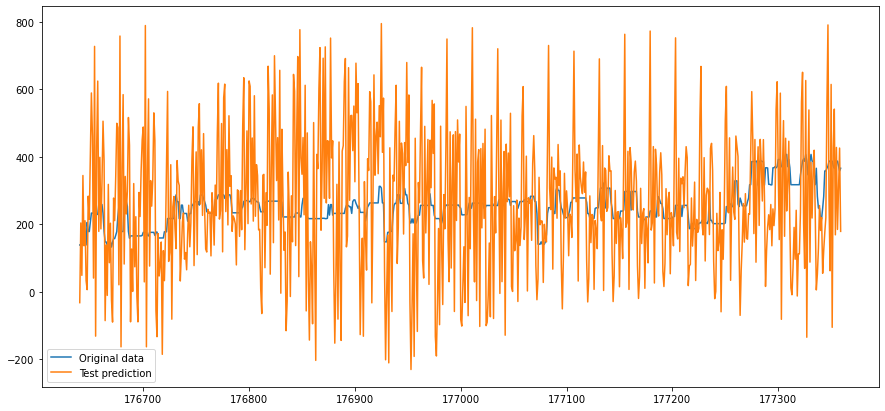

In [56]:
# shift test predictions for plotting
testOriginalPlot = np.zeros((Nt,1))
testOriginalPlot[:, :] = np.nan
testOriginalPlot[len(trainPredict):Nt, :] = testY

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

#### Formato Modelo Probar

In [ ]:
class CustomFullModel(tf.keras.models.Model):
    def __init__(self,output_units):
        super(CustomFullModel, self).__init__()
        self.output_units = output_units

    def build(self, input_shape):

        self.hourly_LSTM_layer_1 = tf.keras.layers.LSTM(units=512,activation='tanh',
                                               kernel_regularizer=tf.keras.regularizers.L1(l1=0),
                                               dropout=0,return_sequences=True)
        self.hourly_LSTM_layer_2 = tf.keras.layers.LSTM(units=64,activation='tanh',
                                                        kernel_regularizer=tf.keras.regularizers.L1(l1=0.105),
                                                        dropout=0.99,return_sequences=True)
        
        self.hourly_TD_Dense_layer_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=120,activation='relu'))
        self.hourly_Dropout_layer_4 = tf.keras.layers.Dropout(rate=0)
        self.hourly_Flatten_layer_5 = tf.keras.layers.Flatten()
        self.hourly_Dense_layer_6 = tf.keras.layers.Dense(units=self.output_units,activation=None)
        
        self.daily_LSTM_layer_1 =  tf.keras.layers.LSTM(units=512,activation='tanh',
                                                        kernel_regularizer=tf.keras.regularizers.L1(l1=0),
                                                        dropout=0.54,return_sequences=False)
        
        self.daily_Dense_layer_2 = tf.keras.layers.Dense(units=self.output_units,activation=None)
        
        self.images_TD_Conv2D_layer_1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=44,
                                                                                       kernel_size=3,
                                                                                       activation='relu',
                                                                                       padding='valid'))
        
        self.images_TD_AvgPool_layer_2 = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling2D(pool_size=3))
        
        self.images_TD_Conv2D_layer_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=20,
                                                                                               kernel_size=7,
                                                                                               activation='relu',
                                                                                               padding='valid'))
        
        self.images_TD_AvgPool_layer_4 = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling2D(pool_size=3))
        self.images_TD_Flatten_layer_5 = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())
        self.images_LSTM_layer_6 = tf.keras.layers.LSTM(units=64,activation='tanh',
                                                        kernel_regularizer=tf.keras.regularizers.L1(l1=0.0075),
                                                        dropout=0.09,
                                                        return_sequences=False,
                                                        stateful=False)
        self.images_Dense_layer_7 = tf.keras.layers.Dense(units=self.output_units,activation=None)
        
        self.Add_Layer = tf.keras.layers.Add()
        self.output_layer = tf.keras.layers.Dense(units=self.output_units,activation=None)
        

    def call(self, inputs, training=None):

        input_1,input_2,input_3 = inputs
        
        hourly_block = self.hourly_LSTM_layer_1(input_1)
        hourly_block = self.hourly_LSTM_layer_2(hourly_block)
        hourly_block = self.hourly_TD_Dense_layer_3(hourly_block)
        hourly_block = self.hourly_Dropout_layer_4(hourly_block, training=training)
        hourly_block = self.hourly_Flatten_layer_5(hourly_block)
        hourly_block = self.hourly_Dense_layer_6(hourly_block)
        
        daily_block = self.daily_LSTM_layer_1(input_2)
        daily_block = self.daily_Dense_layer_2(daily_block)
        
        images_block = self.images_TD_Conv2D_layer_1(input_3)
        images_block = self.images_TD_AvgPool_layer_2(images_block)
        images_block = self.images_TD_Conv2D_layer_3(images_block)
        images_block = self.images_TD_AvgPool_layer_4(images_block)
        images_block = self.images_TD_Flatten_layer_5(images_block)
        images_block = self.images_LSTM_layer_6(images_block)
        images_block = self.images_Dense_layer_7(images_block)
        
        add = self.Add_Layer([hourly_block, daily_block, images_block])
        output = self.output_layer(add)

        return output
    
hourly_input_shape = (72,84)
daily_input_shape = (3,119)
images_input_shape = (3,128,128,6)

input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
input_2 = tf.keras.layers.Input(shape=daily_input_shape)
input_3 = tf.keras.layers.Input(shape=images_input_shape)

m = CustomFullModel(output_units=24)

m([input_1,input_2,input_3],training=False)

m.summary()

In [ ]:
tf.keras.utils.plot_model(m, "mini_resnet.png", show_shapes=True)